#### Imports

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import v2
import matplotlib.pyplot as plt

#### Exploring data

##### Download data

In [2]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_dataset = torchvision.datasets.MNIST(
                root="../data",
                train=True,
                download=True,
                transform=transform
    )

test_dataset = torchvision.datasets.MNIST(
                root="../data",
                train=False,
                download=True,
                transform=transform
    )

##### Explore

In [3]:
print(f"Train Examples: {len(train_dataset)}")
print(f"Test Examples: {len(test_dataset)}")
print(f"Shape of one image: {train_dataset[0][0].shape}")
print(f"Type of an image: {train_dataset[0][0].dtype}") # We transformed it to float32 when we downloaded using transform
print(f"Numbers of pixels in each image: {len(torch.flatten(train_dataset[0][0]))}")

image, label = train_dataset[0]
print(f"Min pixel value: {image.min()}") # 0
print(f"Max pixel value: {image.max()}") # 1 Both because we scaled at download
print(f"Label: {label}")


Train Examples: 60000
Test Examples: 10000
Shape of one image: torch.Size([1, 28, 28])
Type of an image: torch.float32
Numbers of pixels in each image: 784
Min pixel value: 0.0
Max pixel value: 1.0
Label: 5


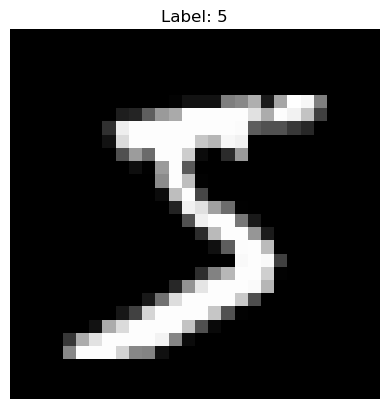

In [4]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

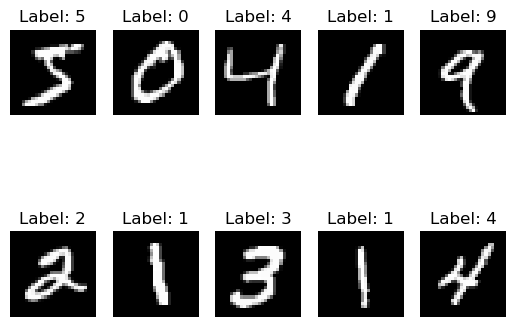

In [5]:
fig, axes = plt.subplots(2,5)
axes = axes.flatten()
for i in range(10):
    image, label = train_dataset[i]
    axes[i].imshow(image.squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
plt.show()

Split to train and validation sets

In [6]:
gen1 = torch.Generator().manual_seed(42)
train_data, val_data = torch.utils.data.random_split(train_dataset,[50000, 10000])

In [7]:
print(f"Training Examples: {len(train_data)}")
print(f"Validation Examples: {len(val_data)}")

train_img, train_label = train_data[0]
val_img, val_label = val_data[0]
print(f"\nTrain sample shape: {train_img.shape}, label: {train_label}")
print(f"Val sample shape: {val_img.shape}, label: {val_label}")

Training Examples: 50000
Validation Examples: 10000

Train sample shape: torch.Size([1, 28, 28]), label: 5
Val sample shape: torch.Size([1, 28, 28]), label: 6


#### Building the CNN

In [10]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=3136, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)

        return x

In [13]:
model = MNIST_CNN()
print(model)
print("=" * 50)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total numbers of parameters: {total_params}")
print(f"Total trainable parameters: {trainable_params}")

MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Total numbers of parameters: 421642
Total trainable parameters: 421642


In [20]:
test_input = torch.randn(4, 1, 28, 28)
print(f"Test tensor shape: {test_input.shape}")
output = model(test_input)
print(f"Test output shape: {output.shape}")
print(f"Output raw results:\n {output}")

Test tensor shape: torch.Size([4, 1, 28, 28])
Test output shape: torch.Size([4, 10])
Output raw results:
 tensor([[-0.0307,  0.0242, -0.0008,  0.0791, -0.0125,  0.0800, -0.0334, -0.0701,
          0.1361,  0.1861],
        [-0.1106,  0.0105,  0.0374,  0.0350, -0.0097,  0.0867, -0.0530, -0.0730,
          0.1498,  0.1782],
        [-0.0297, -0.0706,  0.0472,  0.0345,  0.0117,  0.0782, -0.0217, -0.0370,
          0.1731,  0.1975],
        [-0.0471,  0.0047,  0.0417,  0.0498, -0.0577,  0.0183, -0.1258, -0.1469,
          0.1662,  0.1820]], grad_fn=<AddmmBackward0>)


In [37]:
sample_images = torch.stack([train_data[i][0] for i in range(5)])
sample_labels = [train_data[i][1] for i in range(5)]

print(f"Input shape: {sample_images.shape}")
print(f"True labels: {sample_labels}")

with torch.no_grad():
    output = model(sample_images)

print(f"Output shape: {output.shape}")
print(f"Output raw result: \n{output}")

predictions = output.argmax(dim=1)
print(f"Predictions: \n{predictions.tolist()}")

Input shape: torch.Size([5, 1, 28, 28])
True labels: [5, 1, 5, 6, 6]
Output shape: torch.Size([5, 10])
Output raw result: 
tensor([[-0.0712,  0.0377, -0.0244,  0.0703, -0.0611,  0.0368, -0.0362, -0.0537,
          0.1040,  0.0712],
        [-0.0687,  0.0100, -0.0291,  0.0766, -0.0628,  0.0314, -0.0156, -0.0429,
          0.0907,  0.0687],
        [-0.0583, -0.0122, -0.0278,  0.0616, -0.0733,  0.0547, -0.0259, -0.0453,
          0.1132,  0.0855],
        [-0.0636,  0.0191, -0.0120,  0.0610, -0.0568,  0.0398, -0.0256, -0.0435,
          0.1024,  0.0613],
        [-0.0583,  0.0088, -0.0018,  0.0675, -0.0586,  0.0452, -0.0163, -0.0438,
          0.1087,  0.0617]])
Predictions: 
[8, 8, 8, 8, 8]


In [27]:
batch_size = 64
learning_rate = 0.001
num_epochs = 5

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Batch size: {batch_size}")

Training batches: 782
Validation batches: 157
Batch size: 64


In [ ]:
for epoch in range(num_epochs):
    model.train() 
    running_loss = .0

    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0   

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}] - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%\n')

         